In [60]:
import pymssql
import pandas as pd
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import numpy as np
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer
import sklearn

In [20]:
imputer = KNNImputer()

In [21]:
import pymssql
import pandas as pd

database = "group1"
table = "dbo.capstone_sql_table"
username = "group1user"
password  = "everythingIsAwesome!"
server = "database2108.database.windows.net"

conn = pymssql.connect(server,username, password,database)

cursor = conn.cursor()

In [22]:
query = 'select * from capstone_sql_table'
rawDF = pd.read_sql(query, conn)

In [23]:
orig_shape = rawDF.shape

In [24]:
# Drop the rows in which more than half the columns are null
rawDF.dropna(thresh=orig_shape[1]/2, inplace=True)
# rawDF.dropna(axis=1, thresh=orig_shape[0]/2, inplace=True)
rawDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5222 entries, 0 to 6725
Data columns (total 19 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   year                                                                 5222 non-null   object
 1   country                                                              5222 non-null   object
 2   Stocks traded, total value (% of GDP)                                2143 non-null   object
 3   Inflation, consumer prices (annual %)                                4900 non-null   object
 4   Stocks traded, turnover ratio of domestic shares (%)                 1853 non-null   object
 5   Tax revenue (% of GDP)                                               3076 non-null   object
 6   GDP per capita (current US$)                                         5203 non-null   object
 7   Central governm

In [25]:
# Remove the rows in which the Gini Index value is null
giniDF = rawDF[rawDF['Gini index (World Bank estimate)'].notna()]
impute_DF = giniDF.drop(columns=['country','year','timestamp'])
impute_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641 entries, 0 to 6725
Data columns (total 16 columns):
 #   Column                                                               Non-Null Count  Dtype 
---  ------                                                               --------------  ----- 
 0   Stocks traded, total value (% of GDP)                                898 non-null    object
 1   Inflation, consumer prices (annual %)                                1573 non-null   object
 2   Stocks traded, turnover ratio of domestic shares (%)                 802 non-null    object
 3   Tax revenue (% of GDP)                                               1240 non-null   object
 4   GDP per capita (current US$)                                         1638 non-null   object
 5   Central government debt, total (% of GDP)                            462 non-null    object
 6   Gini index (World Bank estimate)                                     1641 non-null   object
 7   Broad money (% 

In [26]:
# Remove unnecessary columns and change the data types to numeric
impute_DF.drop(columns=['Poverty headcount ratio at national poverty lines (% of population)', 'Income share held by highest 10%', 'Central government debt, total (% of GDP)', 'International migrant stock, total', 'Stocks traded, turnover ratio of domestic shares (%)'], inplace=True)
for col in impute_DF.columns:
    impute_DF[col] = impute_DF[col].apply(pd.to_numeric)
impute_DF.describe()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Gini index (World Bank estimate),Broad money (% of GDP),"Total reserves (includes gold, current US$)","Life expectancy at birth, total (years)","Mortality rate, infant (per 1,000 live births)","Unemployment, total (% of total labor force) (modeled ILO estimate)",Exports of goods and services (% of GDP)
count,898.000000,1573.000000,1240.000000,1638.000000,1641.000000,1256.000000,1.549000e+03,1641.000000,1626.000000,1607.000000,1609.000000
mean,30.612679,14.772602,17.744357,15167.792138,38.443571,52.053622,5.932900e+10,72.502192,21.039852,7.993373,41.294993
std,48.021485,153.546808,6.451471,20161.411709,9.073896,32.789692,2.525419e+11,7.879608,23.658883,5.237647,27.281123
min,0.000858,-4.478103,0.000137,119.684076,20.700000,5.062811,1.163966e+07,42.419000,1.700000,0.210000,4.572485
25%,1.479755,1.767324,13.124104,1959.827425,31.500000,29.753023,1.489443e+09,69.321000,4.600000,4.400000,24.396401
50%,9.954042,3.532082,17.026209,5864.952676,36.400000,46.135774,8.574579e+09,74.100000,12.700000,6.810000,35.189600
75%,40.920085,7.542914,22.118236,21635.725459,44.800000,63.656890,4.160803e+10,78.013000,26.100000,10.030000,51.482535
max,355.519847,4734.914347,62.800376,118823.648369,65.800000,243.034255,3.900039e+12,83.753659,138.600000,37.970000,221.196586


In [27]:
# Drop the other dependent columns
impute_DF.drop(columns=['Life expectancy at birth, total (years)','Mortality rate, infant (per 1,000 live births)','Unemployment, total (% of total labor force) (modeled ILO estimate)'],inplace=True)
impute_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641 entries, 0 to 6725
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Stocks traded, total value (% of GDP)        898 non-null    float64
 1   Inflation, consumer prices (annual %)        1573 non-null   float64
 2   Tax revenue (% of GDP)                       1240 non-null   float64
 3   GDP per capita (current US$)                 1638 non-null   float64
 4   Gini index (World Bank estimate)             1641 non-null   float64
 5   Broad money (% of GDP)                       1256 non-null   float64
 6   Total reserves (includes gold, current US$)  1549 non-null   float64
 7   Exports of goods and services (% of GDP)     1609 non-null   float64
dtypes: float64(8)
memory usage: 115.4 KB


In [28]:
# standardize the data
standard_df = impute_DF.copy(deep=True)
from scipy import stats
for col in standard_df.columns:
    mean = standard_df[col].mean()
    std = standard_df[col].std()
    standard_df[col] = (standard_df[col] - mean)/std
standard_df.describe()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Gini index (World Bank estimate),Broad money (% of GDP),"Total reserves (includes gold, current US$)",Exports of goods and services (% of GDP)
count,8.980000e+02,1.573000e+03,1.240000e+03,1.638000e+03,1.641000e+03,1.256000e+03,1.549000e+03,1.609000e+03
mean,-4.370421e-16,2.500296e-17,1.356890e-16,7.970154e-16,1.210082e-15,-2.264554e-15,1.618030e-16,-2.524671e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.374609e-01,-1.253735e-01,-2.750415e+00,-7.463817e-01,-1.955452e+00,-1.433097e+00,-2.348812e-01,-1.346078e+00
25%,-6.066644e-01,-8.469911e-02,-7.161549e-01,-6.551111e-01,-7.652249e-01,-6.801100e-01,-2.290295e-01,-6.194243e-01
50%,-4.301957e-01,-7.320582e-02,-1.113153e-01,-4.614181e-01,-2.252143e-01,-1.804789e-01,-2.009742e-01,-2.237955e-01
75%,2.146416e-01,-4.708459e-02,6.779662e-01,3.208076e-01,7.005182e-01,3.538694e-01,-7.017043e-02,3.734282e-01
max,6.765871e+00,3.074074e+01,6.983837e+00,5.141300e+00,3.014849e+00,5.824411e+00,1.520821e+01,6.594362e+00


In [29]:
# Fit the imputer to the dataset
columns = list(standard_df.columns)
imputer.fit(standard_df)
# transform the dataset by adding imputations to fill in the blank data
imputed_DF = imputer.transform(standard_df)
final_imputed_DF = pd.DataFrame(imputed_DF, columns = [columns[0],columns[1],columns[2],columns[3],columns[4],columns[5],columns[6]
                                                ,columns[7]])
final_imputed_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Stocks traded, total value (% of GDP)        1641 non-null   float64
 1   Inflation, consumer prices (annual %)        1641 non-null   float64
 2   Tax revenue (% of GDP)                       1641 non-null   float64
 3   GDP per capita (current US$)                 1641 non-null   float64
 4   Gini index (World Bank estimate)             1641 non-null   float64
 5   Broad money (% of GDP)                       1641 non-null   float64
 6   Total reserves (includes gold, current US$)  1641 non-null   float64
 7   Exports of goods and services (% of GDP)     1641 non-null   float64
dtypes: float64(8)
memory usage: 102.7 KB


In [30]:
# Unstandardize the values to make for interpretable predictions by the random forest
for col in final_imputed_DF.columns:
    mean = impute_DF[col].mean()
    std = impute_DF[col].std()
    final_imputed_DF[col] = (std*final_imputed_DF[col])+mean
final_imputed_DF.describe()

,"Stocks traded, total value (% of GDP)","Inflation, consumer prices (annual %)",Tax revenue (% of GDP),GDP per capita (current US$),Gini index (World Bank estimate),Broad money (% of GDP),"Total reserves (includes gold, current US$)",Exports of goods and services (% of GDP)
count,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000,1641.000000,1.641000e+03,1641.000000
mean,21.525757,16.275254,16.789161,15148.115368,38.443571,56.574526,5.638480e+10,41.073753
std,38.362152,152.461608,6.130929,20148.244645,9.073896,32.623727,2.456943e+11,27.097328
min,0.000858,-4.478103,0.000137,119.684076,20.700000,5.062811,1.163966e+07,4.572485
25%,1.603506,1.829741,12.496563,1972.545683,31.500000,33.455640,1.361157e+09,24.396401
50%,6.235634,3.694497,15.781957,5854.418117,36.400000,51.839519,7.578501e+09,34.765813
75%,22.855070,7.941449,20.701428,21601.776399,44.800000,70.989862,3.783215e+10,51.193912
max,355.519847,4734.914347,62.800376,118823.648369,65.800000,243.034255,3.900039e+12,221.196586


In [31]:
#next, split the dataframe for testing and training
from sklearn.model_selection import train_test_split
x = final_imputed_DF.drop(columns=['Gini index (World Bank estimate)'])
y = final_imputed_DF['Gini index (World Bank estimate)'].copy(deep=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [34]:
# use the random forest regressor
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state=0)
regr.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

In [57]:
# get the feature importances
feature_importance = list(regr.feature_importances_)
dict_list = []
i=0
for col in x_test:
    print(f'{col}: {feature_importance[i]}')
    importance_dict = {
        "Feature Name":col,
        "Importance":feature_importance[i]
    }
    dict_list.append(importance_dict)
    i+=1
print(dict_list)
# put the feature importances into a list of dictionaries so that the data can be easily exported

Stocks traded, total value (% of GDP): 0.134196241665585
Inflation, consumer prices (annual %): 0.04378106338912485
Tax revenue (% of GDP): 0.11804467798487321
GDP per capita (current US$): 0.35686690157396633
Broad money (% of GDP): 0.08478327387949315
Total reserves (includes gold, current US$): 0.10362704707860931
Exports of goods and services (% of GDP): 0.15870079442834825
[{'Feature Name': 'Stocks traded, total value (% of GDP)', 'Importance': 0.134196241665585}, {'Feature Name': 'Inflation, consumer prices (annual %)', 'Importance': 0.04378106338912485}, {'Feature Name': 'Tax revenue (% of GDP)', 'Importance': 0.11804467798487321}, {'Feature Name': 'GDP per capita (current US$)', 'Importance': 0.35686690157396633}, {'Feature Name': 'Broad money (% of GDP)', 'Importance': 0.08478327387949315}, {'Feature Name': 'Total reserves (includes gold, current US$)', 'Importance': 0.10362704707860931}, {'Feature Name': 'Exports of goods and services (% of GDP)', 'Importance': 0.158700794428

In [58]:
# export the feature importance data as a CSV
# after trial and error this was a much easier way to do this rather than trying to manipulate data in Power BI
feature_importance_df = pd.DataFrame(dict_list)
feature_importance_df.to_csv('gini_feature_importance.csv',header=True)

In [35]:
# find the score of the original random forest
rf_score = regr.score(x_test, y_test)
print(rf_score)

0.7180905332830934


In [36]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [38]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [39]:
# Although the random search score was better than the grid search in this scenario, after meeting with our mentor
# we decided that the value for bootstrap should be true, we accounted for this on the grid search model
rf_random.score(x_test,y_test)

0.7303772900705758

In [40]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search and instructions from our mentor
param_grid = {
    'bootstrap': [True],
    'max_features': [2, 3, 4, 5, 6, 7],
    'max_depth':[None],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [100, 200, 300, 1000]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = regr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [41]:
# Fit the grid search to the data
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.57385384 0.57186901
 0.57577336 0.57854193 0.57385384 0.57186901 0.57577336 0.57854193
        nan        nan        nan        nan 0.55527192 0.55928213
 0.56097397 0.56004627 0.55527192 0.55928213 0.56097397 0.56004627
        nan        nan        nan        nan 0.53400975 0.53824491
 0.54015228 0.5409125  0.53400975 0.53824491 0.54015228 0.5409125
        nan        nan        nan        nan 0.58618231 0.58944801
 0.5896336  0.59273797 0.58618231 0.58944801 0.5896336  0.59273797
        nan        nan        nan        nan 0.57459851 0.57456431
 0.57348722 0.5776298  0.57459851 0.57456431 0.57348722 0.5776298
        nan        nan        nan        nan 0.55823933 0.55851692
 0.55743996 0.56115767 0.55823933 0.55851692 0.55743996 0.56115767
        nan        nan        nan        nan 0.59534772

{'bootstrap': True,
 'max_depth': None,
 'max_features': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [42]:
# used this score for the final model as it accounts for advise from our mentor and hypertunes the parameters
grid_search.score(x_test,y_test)

0.7114966896752943

In [43]:
grid_predictions = grid_search.predict(x_test)
grid_predictions

array([32.21579345, 49.75308821, 31.66987683, 40.69157948, 31.65390957,
       38.58580958, 35.44536778, 27.39998501, 40.10370058, 46.09403392,
       34.41237646, 44.08815988, 31.73654818, 34.70033204, 27.16785464,
       39.27883782, 38.63605825, 31.18849337, 48.1303521 , 33.59502397,
       32.95533766, 49.04645855, 40.8330727 , 31.22159777, 37.1450356 ,
       39.40261167, 30.42630746, 52.15878802, 33.88973599, 33.7617043 ,
       45.60570397, 39.40954794, 41.33956847, 46.63790075, 49.28691099,
       32.08661511, 44.65131317, 28.1337475 , 42.72514882, 40.10294159,
       43.71149448, 35.39611373, 27.31139282, 33.6604152 , 47.60168718,
       40.56327167, 46.24408218, 32.74868472, 27.02209171, 43.85444095,
       35.56513544, 29.21881397, 33.46720022, 32.95505702, 43.78629143,
       30.48967813, 40.2193977 , 32.6534631 , 35.34634619, 27.29152396,
       39.95190571, 47.06005563, 47.41264565, 41.48639468, 40.40968766,
       28.9048325 , 46.60996567, 45.0087646 , 45.10790754, 32.63

In [45]:
# reset the index of the test frame so that we can make the predicted vs. actual values line up
y_test1 = y_test.to_frame()
y_test1.reset_index(inplace=True)
y_test1.drop(['index'],axis=1,inplace=True)
g_y_test = y_test1.squeeze()

In [46]:
# create a dataframe for the actual vs. predicted and the residuals
residuals = grid_predictions - g_y_test
d = {'Actual': g_y_test, 'Predicted': grid_predictions, 'Residuals': residuals}
df = pd.DataFrame(data=d)
df

,Actual,Predicted,Residuals
0,28.8,32.215793,3.415793
1,58.7,49.753088,-8.946912
2,32.9,31.669877,-1.230123
3,40.9,40.691579,-0.208421
4,31.3,31.653910,0.353910
...,...,...,...
406,41.3,40.289778,-1.010222
407,43.4,42.613748,-0.786252
408,39.3,44.814071,5.514071
409,30.7,40.876315,10.176315


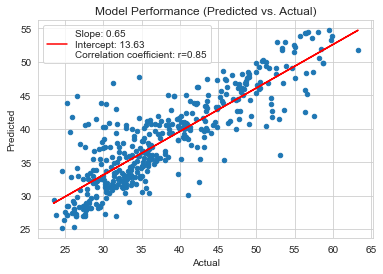

In [47]:
# Predictions vs. Actual Scatter Plot
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('whitegrid')

ax1 = df.plot(title = 'Model Performance (Predicted vs. Actual)', kind='scatter', x='Actual',y='Predicted')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predicted')

# Set up trendline
x = df['Actual'].to_numpy()
y = df['Predicted'].to_numpy()
# Call the lin regression package to analyze the x and y values
scipy.stats.linregress(x,y)

# Calculate Linear Regression
slope, intercept, r, p, stderr = scipy.stats.linregress(x,y)

# Display Results
line = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nCorrelation coefficient: r={r:.2f}'

# Add the line to the graph
ax1.plot(x, intercept + slope * x, label=line,color='red')

# Set up the legend
ax1.legend(facecolor='white')

# Show the plot
plt.show()

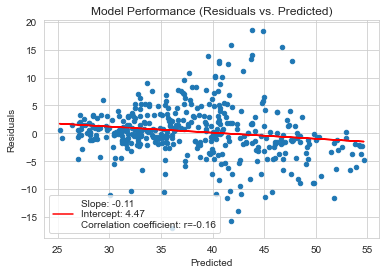

In [48]:
# Predictions vs. Residuals Scatter Plot
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('whitegrid')

ax1 = df.plot(title = 'Model Performance (Residuals vs. Predicted)', kind='scatter', x='Predicted',y='Residuals')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Residuals')

# Set up trendline
x = df['Predicted'].to_numpy()
y = df['Residuals'].to_numpy()
# Call the lin regression package to analyze the x and y values
scipy.stats.linregress(x,y)

# Calculate Linear Regression
slope, intercept, r, p, stderr = scipy.stats.linregress(x,y)

# Display Results
line = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nCorrelation coefficient: r={r:.2f}'

# Add the line to the graph
ax1.plot(x, intercept + slope * x, label=line,color='red')

# Set up the legend
ax1.legend(facecolor='white')

# Show the plot
plt.show()

In [49]:
# export the model to a pickle file so that it can be used in other notebooks and Power BI
import pickle
filename = 'gini_index_final_model_with_imputation.pkl'
pickle.dump(grid_search, open(filename, 'wb'))